# Thesis Bell KPI Notebook
This notebook explores regression models applied to daily kpi data  

In [109]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import datetime as dt
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn import linear_model
from scipy import stats
import scipy.signal as sig
import statsmodels.api as sm

#importing the data
kpi = pd.read_excel("productivity.xlsx")
weather = pd.read_excel("weather.xlsx")
weather = weather[weather["Total Precip Flag"] != "T"]
weather = weather.set_index(weather["Date/Time"])
kpi = kpi.set_index(kpi["Date"])
kpi["Date"] = pd.to_datetime(kpi["Date"], format="%m/%d/%Y")
#group the data by date and get the aggregate daily kpis
grouped = kpi.groupby('Date')
kpi = kpi[kpi.index.dayofweek <5]
#unit_kpi = pd.DataFrame(grouped.sum()["Locations Passed"]/grouped.count()['Foreman'])


## I am going to use the index of adding up all the work being done
#### Each unit of work gets paid at different rates however for simplicity 

In [110]:
#add up all the metres drilled work 
unit_kpi = pd.DataFrame((grouped.sum()["Metres Prepped"]+grouped.sum()["Meters Drilled"]+grouped.sum()["Meters Cleaned Up"])/grouped.count()['Foreman'])
unit_kpi["Date/Time"] = unit_kpi.index

unit_kpi.columns = ['kpi', 'Date/Time']
unit_kpi = unit_kpi.dropna()
full_data = pd.merge(unit_kpi,weather,on = "Date/Time")
full_data = full_data[full_data.kpi <550] #I have been informed that these days are 
#called adjustment days that are not actually occuring on the day it is logged 

## Two useful functions 
#### One for verifying iidness and one for plotting mahalanobis contours for robust covariance estimation

In [111]:
#%%
#testing for iidness
def iid(invariants):
    """takes in a series and does iid analysis on the time series"""
    plt.figure(1)
    invariants = invariants.fillna(0)
    length = len(invariants)
    first_half = invariants[0:length//2]
    second_half = invariants[length//2+1:length]
    l = pd.concat([first_half, second_half], axis = 1)
    l.columns = ['1st', '2nd']
    plt.subplot(2,2,1)
    plt.tight_layout()
    first_half.plot(kind = "kde")
    plt.title('First Half of Series Histogram',size = 8)
    plt.ylabel("Count",fontsize = 8)
    plt.subplot(2,2,2)
    second_half.plot(kind = "kde")
    plt.title('Second Half of Series Histogram',size = 8)
    plt.ylabel("Count",fontsize = 8)
    plt.subplot(2,2,3)
    pd.tools.plotting.lag_plot(invariants)
    plt.title('Lag Plot',size = 8)
    print(np.corrcoef(first_half,second_half))
    plt.subplot(2,2,4)
    plt.plot(invariants,"*")
    plt.title('Scatter Plot',size = 8)
    plt.ylabel("Residuals",fontsize = 8)
    plt.figure(2)
    from pandas.tools.plotting import autocorrelation_plot
    autocorrelation_plot(invariants)
    plt.title('Autocorrelation Plot')

def mahal_plot(e):
  first_half = e[1:len(e)  - 1]
  second_half = e[2:len(e)]
  X = np.array([first_half, second_half]) 
  X = np.transpose(X)                          
# fit a Minimum Covariance Determinant (MCD) robust estimator to data
  robust_cov = MinCovDet().fit(X)

# compare estimators learnt from the full data set with true parameters
  emp_cov = EmpiricalCovariance().fit(X)


  fig = plt.figure()

# Show data set
  subfig1 = plt.subplot(1, 1, 1)
  inlier_plot = subfig1.scatter(first_half, second_half,
                              color='black', label='daily diff in homes passed')

  subfig1.set_title("Mahalanobis distances of the iid invariants:")

# Show contours of the distance functions
  xx, yy = np.meshgrid(np.linspace(plt.xlim()[0], plt.xlim()[1], 800),
                     np.linspace(plt.ylim()[0], plt.ylim()[1], 100))

  zz = np.c_[xx.ravel(), yy.ravel()]

  mahal_emp_cov = emp_cov.mahalanobis(zz)
  mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
  emp_cov_contour = subfig1.contour(xx, yy, np.sqrt(mahal_emp_cov),
                                  cmap=plt.cm.PuBu_r,
                                  linestyles='dashed')

  mahal_robust_cov = robust_cov.mahalanobis(zz)
  mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
  robust_contour = subfig1.contour(xx, yy, np.sqrt(mahal_robust_cov),
                                 cmap=plt.cm.YlOrBr_r, color = 'red',linewidth = "3")

  subfig1.legend([emp_cov_contour.collections[1], robust_contour.collections[1],
                inlier_plot],
               ['MLE dist', 'robust dist', 'kpis'],
               loc="upper right", borderaxespad=0)
  print(np.corrcoef(first_half,second_half))
  return (robust_cov, emp_cov)

## Dropping a lot of useless fields

In [112]:
full_data = full_data.drop(['Year', 'Month', 'Day', 'Data Quality','Max Temp (°C)', 
                            'Max Temp Flag', 'Min Temp (°C)', 'Min Temp Flag',
                            'Mean Temp Flag',
                            'Heat Deg Days Flag', 
                            'Cool Deg Days Flag','Total Precip Flag',
                            'Snow on Grnd (cm)', 'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)',
                             'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)',
                              'Spd of Max Gust Flag','Total Rain Flag','Total Snow (cm)','Total Snow Flag'],axis =1)

## Regression Model #1
$M_{t} = \alpha_0 + \alpha_1M_{t-1} + \alpha_2T_t + \alpha_3T_t^2+\alpha_4P_t + \epsilon_t$
where $\epsilon_t$ is $iid$

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     8.869
Date:                Fri, 29 Sep 2017   Prob (F-statistic):           2.11e-06
Time:                        01:01:46   Log-Likelihood:                -819.53
No. Observations:                 142   AIC:                             1647.
Df Residuals:                     138   BIC:                             1659.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Mean Temp (°C)        3.8342      1.32

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


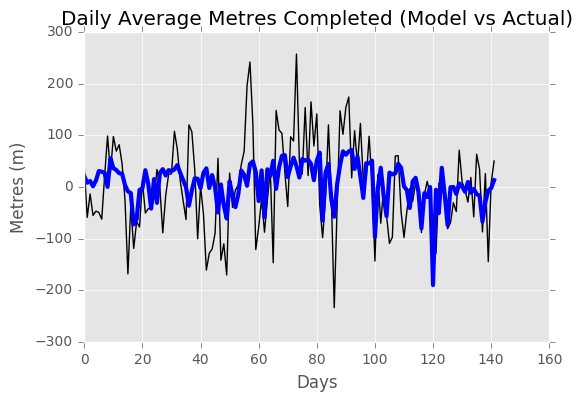

In [147]:
#Regression Model 

factors = full_data.dropna()
X = factors[["Mean Temp (°C)",'Total Precip (mm)']][1:]
X["T squared"]= factors["Mean Temp (°C)"]**2
X["lag kpi"] = list(factors["kpi"])[0:-1]
Y = factors.kpi[1:]
Y = list(pd.Series(sig.detrend(Y)))
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

Yp = results.predict()
e = Y  - Yp

plt.plot(Y,  color='black')
plt.plot(Yp, color='blue',linewidth=3)
plt.title('Daily Average Metres Completed (Model vs Actual)')
plt.ylabel("Metres (m)")
plt.xlabel("Days")
plt.legend()

[[ 1.         -0.02686623]
 [-0.02686623  1.        ]]


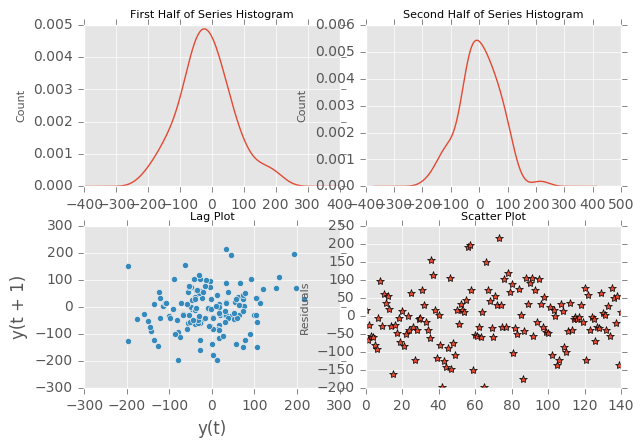

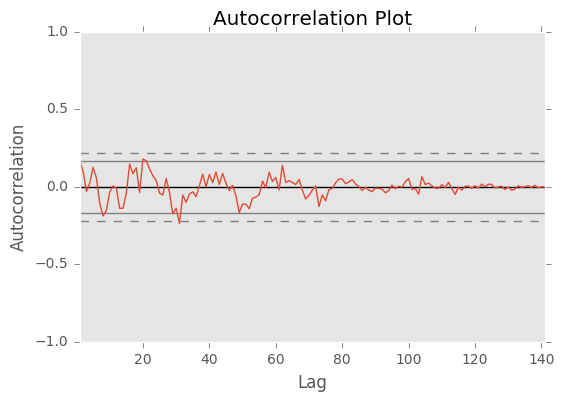

In [146]:
iid(pd.Series(e[:-1]))

## Regression Model #2
$M_{t} = \alpha_0 + \alpha_1M_{t-1} + \alpha_2M_{t-2} + \alpha_3T_t^2+\alpha_4P_t + \epsilon_t$
where $\epsilon_t$ is $iid$

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     5.726
Date:                Fri, 29 Sep 2017   Prob (F-statistic):           0.000272
Time:                        01:01:54   Log-Likelihood:                -819.40
No. Observations:                 141   AIC:                             1647.
Df Residuals:                     137   BIC:                             1659.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Mean Temp (°C)       -0.2039      0.72

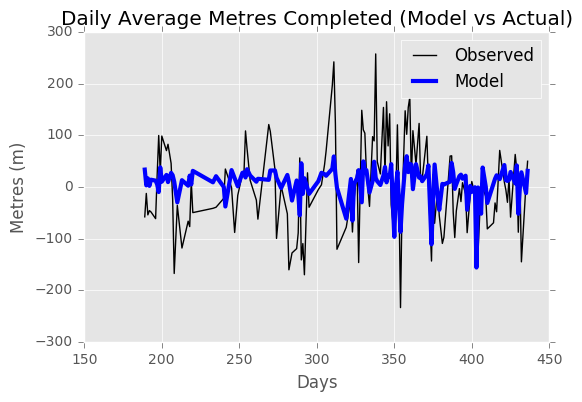

In [148]:
#%% Regression Model 

factors = full_data.dropna()
factors["lnT"] = np.log(1.8*full_data['Mean Temp (°C)']+32)

l = list(weather['Total Precip (mm)'])
S = []  
s = 0
for i in range(len(l)):
  if l[i] >0.1:
    s += l[i]
  else:
    s = 0
  S.append(s)
  
weather["cumPrecip"] = S

factors = pd.merge(factors, weather[["Date/Time","cumPrecip"]], on = "Date/Time")
factors['dt'] = (factors["Date/Time"] - factors["Date/Time"][0]).apply(lambda x: float(x.total_seconds()/86400))
X = factors[["Mean Temp (°C)",'Total Precip (mm)']][2:]
X["lag kpi_1"] = list(factors["kpi"])[1:-1]
X["lag kpi_2"] = list(factors["kpi"])[0:-2]
#X["T2"] = (X["Mean Temp (°C)"][0:-31]**2)/max(X["Mean Temp (°C)"][0:-31]**2)
Y = factors.kpi[2:]
Y = list(pd.Series(sig.detrend(Y)))
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

Yp = results.predict()
e = Y  - Yp

plt.plot(factors['dt'][2:], Y,  color='black',label = "Observed")
plt.plot(factors['dt'][2:], Yp, color='blue',linewidth=3,label = "Model")
plt.title('Daily Average Metres Completed (Model vs Actual)')
plt.ylabel("Metres (m)")
plt.xlabel("Days")
plt.legend()

[[ 1.         -0.08223043]
 [-0.08223043  1.        ]]


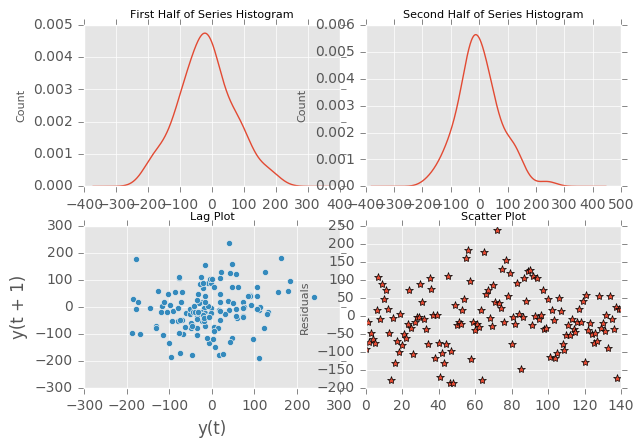

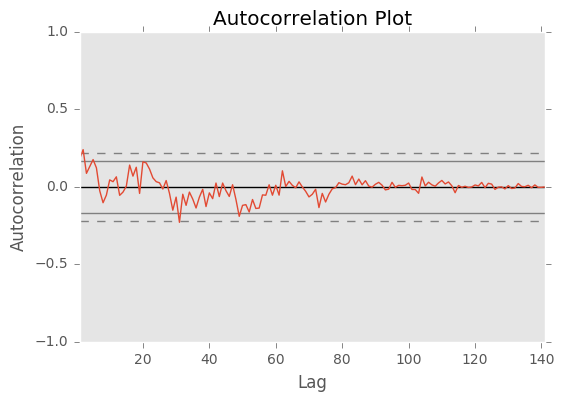

In [150]:
iid(pd.Series(e))

[[ 1.          0.18433143]
 [ 0.18433143  1.        ]]


(MinCovDet(assume_centered=False, random_state=None, store_precision=True,
      support_fraction=None),
 EmpiricalCovariance(assume_centered=False, store_precision=True))

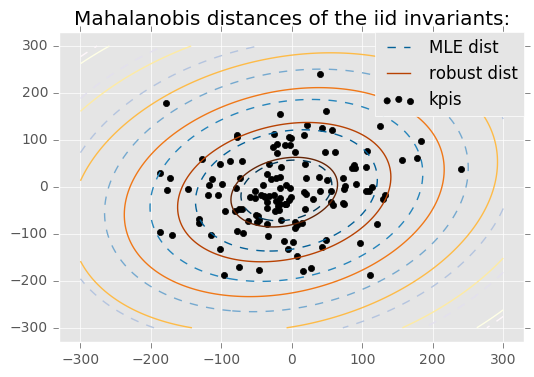

In [151]:
mahal_plot(e)

# Optimal lag selection using AR process (tutorial)
$M_{t+1} = \alpha_0 + \alpha_1M_t + \epsilon_t$
where $\epsilon_t$ is $iid$

In [32]:
full_data.index = full_data["Date/Time"]
full_data
model = sm.tsa.AR(full_data.kpi)
results= model.fit(maxlag = 10, ic = "aic",method = 'cmle')

In [30]:
a = sm.tsa.AR(full_data.kpi).select_order(maxlag = 10, ic = 'aic',method='cmle')

In [35]:
a

1

In [34]:
results.params

const     138.074416
L1.kpi      0.412172
dtype: float64

## Regression model #3
why try and get the iid invariants all at once... instead try and model the residuals separately as it is supported by literature as per Koehen&Brown:

$M_{t} = \alpha_0 + \alpha_1T_t +\alpha_2T_t^2+\alpha_4P_t + \epsilon_t$
where $\epsilon_t$ is $iid$ ? Most likely not so lets use a k lag auto regression process

$\epsilon_t = \sum_{i = 1}^{k} \rho_i \epsilon_{t-i} + \zeta_t$

where $\zeta_t$ is iid

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     6.133
Date:                Fri, 29 Sep 2017   Prob (F-statistic):           0.000600
Time:                        01:02:32   Log-Likelihood:                -833.63
No. Observations:                 143   AIC:                             1673.
Df Residuals:                     140   BIC:                             1682.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Mean Temp (°C)        4.3241      1.38

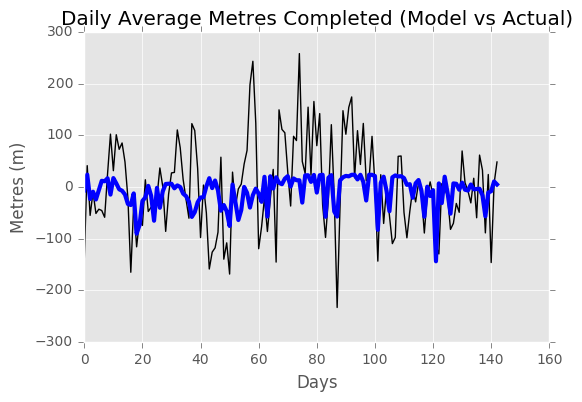

In [152]:
factors = full_data.dropna()
X = factors[["Mean Temp (°C)",'Total Precip (mm)']]
X["Mean Temp Squared"]= factors["Mean Temp (°C)"]**2
Y = factors.kpi
Y = list(pd.Series(sig.detrend(Y))) #linear detrending for now
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

Yp = results.predict()
e = Y  - Yp

plt.plot(Y,  color='black')
plt.plot(Yp, color='blue',linewidth=3)
plt.title('Daily Average Metres Completed (Model vs Actual)')
plt.ylabel("Metres (m)")
plt.xlabel("Days")
plt.legend()

[[ 1.        -0.0382532]
 [-0.0382532  1.       ]]


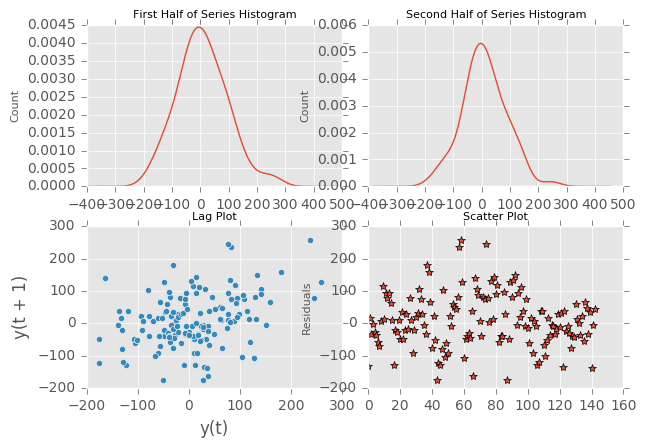

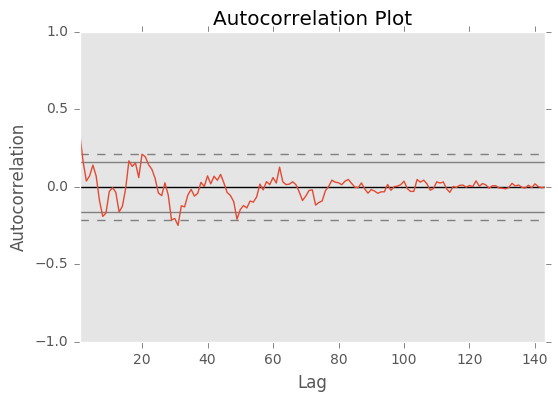

In [153]:
iid(pd.Series(e))

In [154]:
model = sm.tsa.AR(e)
results= model.fit(maxlag = 30, ic = "bic",method = 'cmle')
print("The maximum number of required lags for the residuals above according to the Bayes Information Criterion is:")
sm.tsa.AR(e).select_order(maxlag = 10, ic = 'aic',method='cmle')

The maximum number of required lags for the residuals above according to the Bayes Information Criterion is:


1

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     20.25
Date:                Fri, 29 Sep 2017   Prob (F-statistic):           1.41e-05
Time:                        01:02:52   Log-Likelihood:                -817.48
No. Observations:                 142   AIC:                             1637.
Df Residuals:                     141   BIC:                             1640.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3515      0.078      4.500      0.0

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


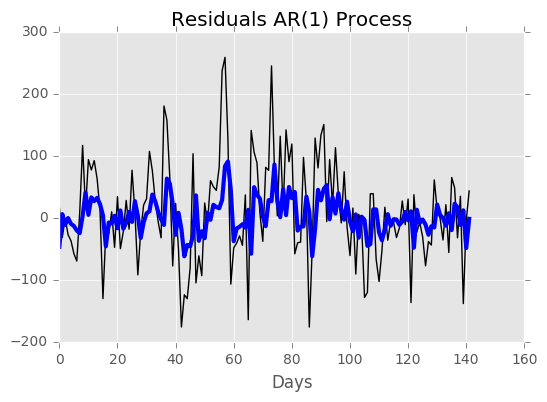

In [155]:
res_mod = sm.OLS(e[1:], e[:-1])
res_res = res_mod.fit()
print(res_res.summary())

ep = res_res.predict()
print(len(ep),len(e))
z = ep - e[1:]

plt.plot(e[1:],  color='black')
plt.plot(ep, color='blue',linewidth=3)
plt.title('Residuals AR(1) Process')
plt.ylabel(" ")
plt.xlabel("Days")
plt.legend()

[[ 1.         -0.00438637]
 [-0.00438637  1.        ]]


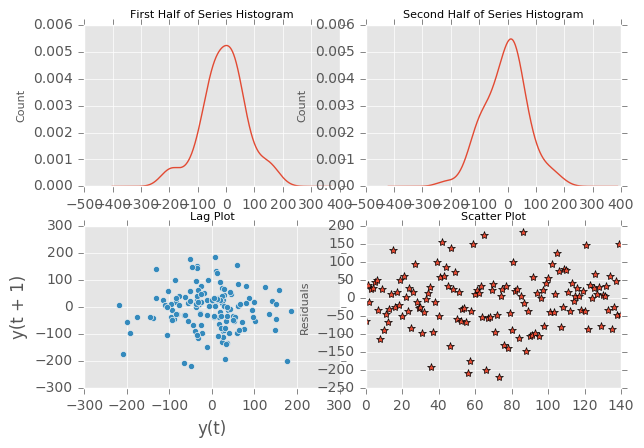

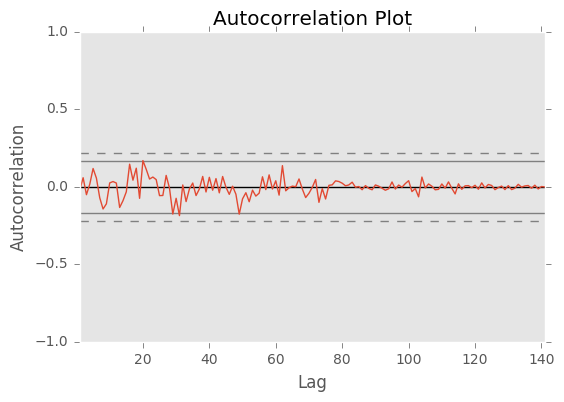

In [157]:
iid(pd.Series(z)[:-1])